In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [6]:
# Load the dataset
data = pd.read_csv('results_complete_take_4.csv')
data = data[data['hazard_type'] == 'inhalation']
# Display the first few rows of the dataframe
data.head()

,study_id,elev_m,ave_nbp_deg_k,overall_ave_mw,storage_ave_vap_mw,storage_key_component,storage_shi,storage_lfl,storage_temp_deg_k,storage_vapor_mol_composition,...,log_discharge_shi_times_component_total_moles,log_release_duration_sec,log_catastrophic_release_01,log_discharge_diameter_in,log_release_orientation,log_press_psia,log_conc_low_ppm,log_area_conc_low_m2,log_conc_high_ppm,log_area_conc_high_m2
0,2693,3.0,280.223403,45.08368,45.08368,124-40-3,0.002857,28000.0,299.85,1.0,...,2.116055,1.000000,0,0.90309,-10.0,2.129354,2.544068,7.882827,3.544068,7.111400
1,2789,0.0,239.159315,70.90600,70.90600,7782-50-5,0.050000,NaN,298.15,1.0,...,1.802530,3.556303,-10,-0.30103,-10.0,2.331824,1.301030,7.294542,2.301030,6.592582
2,3823,0.0,239.747566,17.03052,17.03052,7664-41-7,0.000667,150000.0,298.15,1.0,...,2.592681,3.556303,-10,1.00000,-10.0,2.711551,3.176091,7.514013,4.176091,6.539190
3,2785,0.0,239.159315,70.90600,70.90600,7782-50-5,0.050000,NaN,298.15,1.0,...,1.802530,3.556303,-10,0.90309,-10.0,2.331824,1.301030,7.231630,2.301030,6.452328
5,4015,0.0,239.159315,70.90600,70.90600,7782-50-5,0.050000,NaN,298.15,1.0,...,2.848287,3.556303,-10,1.00000,-10.0,2.711551,1.301030,7.142604,2.301030,6.261738


In [95]:
data = data.dropna()
X = data.drop(columns=['hazard_type'])
X = X[X.columns.drop(list(X.filter(regex='key_component')))]
X = X[X.columns.drop(list(X.filter(regex='catastrophic_release')))]
X = X.filter(regex='log')
X = X[X>-10]
X = (X-X.mean())/X.std()
X.to_csv('standardized.csv')
y = X['log_area_conc_high_m2']
X = X[X.columns.drop(list(X.filter(regex='area_conc')))]

In [92]:
# Calculate the correlation coefficients
correlation = X.corrwith(y).sort_values(ascending=False)
correlation[correlation > 0.2]

log_discharge_shi_times_vapor_mol_composition    0.413847
log_discharge_shi                                0.412944
log_storage_shi_times_vapor_mol_composition      0.411544
log_storage_shi                                  0.406620
log_storage_vapor_mol_composition                0.268072
log_storage_shi_times_component_total_moles      0.265560
log_discharge_shi_times_component_total_moles    0.263616
log_discharge_vapor_mol_composition              0.254157
log_discharge_shi_times_total_moles              0.236540
log_storage_shi_times_total_moles                0.236167
dtype: float64

In [93]:
# Select top contributing variables based on correlation
top_features = correlation[correlation > 0.4].index.tolist()

# Prepare the X matrix with top features
X_top = X[top_features]
X_top = X_top.dropna()

X_top.describe()

,log_discharge_shi_times_vapor_mol_composition,log_discharge_shi,log_storage_shi_times_vapor_mol_composition,log_storage_shi
count,9.130000e+02,9.130000e+02,9.130000e+02,9.130000e+02
mean,3.113002e-17,-6.226004e-17,2.801702e-16,7.471205e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.588934e+00,-2.614736e+00,-3.784440e+00,-4.466151e+00
25%,-6.386490e-01,-7.870310e-01,-5.953881e-01,-7.733259e-01
50%,3.686442e-01,3.129047e-01,3.329990e-01,3.073548e-01
75%,7.271603e-01,7.426262e-01,7.124231e-01,7.359519e-01
max,3.687820e+00,4.832110e+00,3.568852e+00,4.757341e+00


In [94]:


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42)

# Fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate the R^2 score
r2 = r2_score(y_test, y_pred)
print(f'R^2 Score: {r2:.2f}')

R^2 Score: 0.24


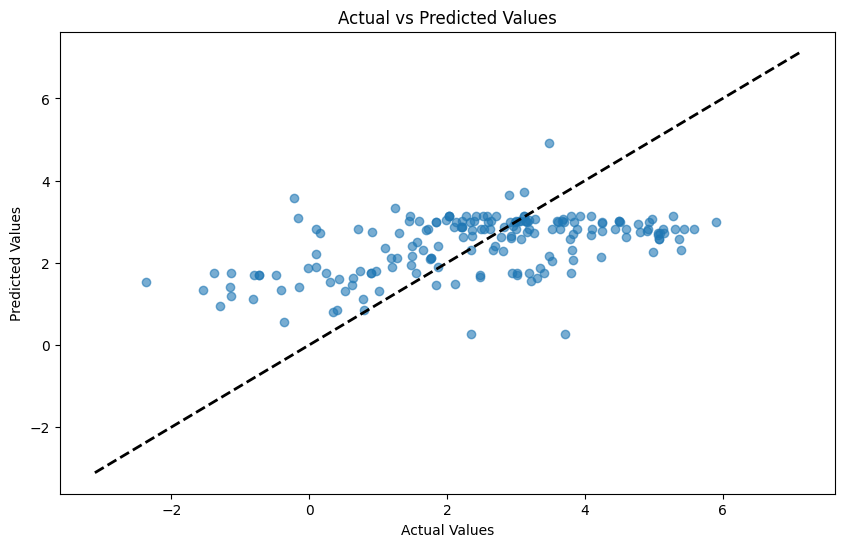

In [82]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()